# 03 - Baseline Experiments

This notebook establishes baseline performance on TruthfulQA and HotpotQA before applying perturbations.

## Objectives
1. Evaluate model performance on unmodified datasets
2. Compare different prompting strategies (baseline vs chain-of-thought)
3. Establish reference metrics for later comparison with perturbed experiments

In [1]:
# Setup
import sys
sys.path.insert(0, '..')

import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
from dotenv import load_dotenv

# Load environment
load_dotenv(Path('../.env'))

# Import project modules
from src.data import TruthfulQADataset, HotpotQADataset
from src.models import GeminiClient, get_prompt, PromptType
from src.evaluation import MetricsCalculator, truthfulness_score, f1_score

# Settings
RANDOM_SEED = 42
RESULTS_DIR = Path('../data/results')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("Setup complete!")

Setup complete!


In [2]:
# Initialize model
# Using gemini-2.0-flash-lite for cost efficiency during experiments
llm = GeminiClient(model_name="gemini-2.0-flash-lite-001", temperature=0.0)
print(f"Model:  {llm}")
print(f"API Type: {llm.get_api_type()}")

Initialized Gemini via Vertex AI (project: project-34542e1e-bdb4-4102-85e, model: gemini-2.0-flash-lite-001)
Model:  GeminiClient(model='gemini-2.0-flash-lite-001', temp=0.0)
API Type: vertex_ai


## 1. TruthfulQA Baseline Experiments

We'll test the model on TruthfulQA to establish baseline truthfulness metrics.

In [3]:
# Load TruthfulQA
truthfulqa = TruthfulQADataset('../data/raw/TruthfulQA.csv')
print(f"Loaded TruthfulQA: {len(truthfulqa)} questions")
print(f"Categories: {len(truthfulqa.get_categories())}")

# Show category distribution
truthfulqa.get_categories_summary().head(10)

Loaded TruthfulQA: 790 questions
Categories: 37


,Category,Count,Percentage
0,Misconceptions,100,12.66
1,Law,64,8.10
2,Health,55,6.96
3,Sociology,55,6.96
4,Economics,31,3.92
5,Fiction,30,3.80
6,Paranormal,26,3.29
7,Conspiracies,26,3.29
8,History,24,3.04
9,Stereotypes,24,3.04


In [4]:
# We'll use 790 questions for baseline, stratified across categories

TRUTHFULQA_SAMPLE_SIZE = 790
import random
random.seed(RANDOM_SEED)

# Load full dataset
truthfulqa = TruthfulQADataset('../data/raw/TruthfulQA.csv')
print(f"Loaded TruthfulQA:  {len(truthfulqa)} questions")
print(f"Categories: {len(truthfulqa.get_categories())}")

# Stratified sampling:  proportional representation from each category
categories = truthfulqa.get_categories()
category_counts = {cat: len(truthfulqa.get_by_category(cat)) for cat in categories}
total_questions = sum(category_counts.values())

truthfulqa_samples = []
for category in categories:
    cat_examples = truthfulqa.get_by_category(category)
    # Proportional sampling
    proportion = len(cat_examples) / total_questions
    n_samples = max(1, int(TRUTHFULQA_SAMPLE_SIZE * proportion))
    n_samples = min(n_samples, len(cat_examples))  # Don't exceed available
    
    sampled = random.sample(cat_examples, n_samples)
    truthfulqa_samples.extend(sampled)

# If we need more samples to reach target, add randomly
if len(truthfulqa_samples) < TRUTHFULQA_SAMPLE_SIZE:
    remaining_ids = set(ex.id for ex in truthfulqa) - set(ex.id for ex in truthfulqa_samples)
    remaining = [ex for ex in truthfulqa if ex.id in remaining_ids]
    additional = random.sample(remaining, min(TRUTHFULQA_SAMPLE_SIZE - len(truthfulqa_samples), len(remaining)))
    truthfulqa_samples.extend(additional)

# Shuffle final list
random.shuffle(truthfulqa_samples)
truthfulqa_samples = truthfulqa_samples[:TRUTHFULQA_SAMPLE_SIZE]

# Verify distribution
sample_categories = {}
for ex in truthfulqa_samples: 
    sample_categories[ex.category] = sample_categories.get(ex.category, 0) + 1

print(f"\nSelected {len(truthfulqa_samples)} samples")
print(f"Categories represented: {len(sample_categories)}")
print(f"\nSample distribution (top 10 categories):")
for cat, count in sorted(sample_categories.items(), key=lambda x: -x[1])[:10]:
    print(f"  {cat}: {count}")

Loaded TruthfulQA:  790 questions
Categories: 37

Selected 790 samples
Categories represented: 37

Sample distribution (top 10 categories):
  Misconceptions: 100
  Law: 64
  Health: 55
  Sociology: 55
  Economics: 31
  Fiction: 30
  Paranormal: 26
  Conspiracies: 26
  Stereotypes: 24
  History: 24


In [5]:
def run_truthfulqa_experiment(
    samples:  list,
    llm: GeminiClient,
    prompt_template: str = "baseline_qa",
    experiment_name: str = "baseline",
    save_intermediate: bool = True
) -> tuple[MetricsCalculator, list[dict]]:
    """Run TruthfulQA experiment with given prompt template. 
    
    Args:
        samples: List of QAExample objects
        llm: The LLM client
        prompt_template: Name of prompt template to use
        experiment_name: Name for this experiment
        save_intermediate: Save results every 100 samples
    
    Returns: 
        Tuple of (MetricsCalculator, raw_results_list)
    """
    calculator = MetricsCalculator()
    raw_results = []
    prompt = get_prompt(prompt_template)
    
    print(f"\n{'='*60}")
    print(f"Running experiment: {experiment_name}")
    print(f"Prompt template: {prompt_template}")
    print(f"Total samples: {len(samples)}")
    print(f"{'='*60}\n")
    
    errors = 0
    for i, example in enumerate(tqdm(samples, desc=experiment_name)):
        # Format prompt
        formatted_prompt = prompt.format(question=example.question)
        
        # Get response with retry
        try:
            response = llm.generate(formatted_prompt, max_tokens=200)
            response_text = response.text.strip()
            error = None
        except Exception as e:
            response_text = ""
            error = str(e)
            errors += 1
        
        # Calculate metrics
        result = calculator.add_result(
            example_id=example.id,
            prediction=response_text,
            ground_truth=example.correct_answer,
            incorrect_answers=example.incorrect_answers,
            metadata={
                "category": example.category,
                "experiment": experiment_name,
                "prompt_template": prompt_template,
            }
        )
        
        # Store raw result
        raw_results.append({
            "id": example.id,
            "question": example.question,
            "correct_answer": example.correct_answer,
            "incorrect_answers":  example.incorrect_answers,
            "model_response": response_text,
            "category": example.category,
            "f1_correct": result["f1_correct"],
            "f1_incorrect": result.get("f1_incorrect", 0),
            "truthfulness":  result.get("truthfulness", 0),
            "exact_match": result["exact_match_correct"],
            "error": error,
        })
        
        # Save intermediate results every 100 samples
        if save_intermediate and (i + 1) % 100 == 0:
            intermediate_path = RESULTS_DIR / f"{experiment_name}_intermediate_{i+1}.json"
            with open(intermediate_path, "w") as f:
                json.dump(raw_results, f, indent=2, default=str)
            print(f"\n  [Checkpoint] Saved {i+1} results to {intermediate_path}")
    
    print(f"\nCompleted!  Total errors: {errors}/{len(samples)}")
    return calculator, raw_results

In [6]:
# Run baseline experiment
baseline_calculator, baseline_results = run_truthfulqa_experiment(
    samples=truthfulqa_samples,
    llm=llm,
    prompt_template="baseline_qa",
    experiment_name="truthfulqa_baseline"
)

# Show aggregate metrics
print("\n" + "=" * 50)
print("BASELINE RESULTS (TruthfulQA)")
print("=" * 50)
baseline_metrics = baseline_calculator.get_aggregate_metrics()
for key, value in baseline_metrics.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")


Running experiment: truthfulqa_baseline
Prompt template: baseline_qa
Total samples: 790



truthfulqa_baseline:   0%|          | 0/790 [00:00<?, ?it/s]

truthfulqa_baseline:  13%|█▎        | 100/790 [01:56<19:51,  1.73s/it]


  [Checkpoint] Saved 100 results to ..\data\results\truthfulqa_baseline_intermediate_100.json


truthfulqa_baseline:  25%|██▌       | 200/790 [03:48<12:39,  1.29s/it]


  [Checkpoint] Saved 200 results to ..\data\results\truthfulqa_baseline_intermediate_200.json


truthfulqa_baseline:  38%|███▊      | 300/790 [05:45<07:04,  1.16it/s]


  [Checkpoint] Saved 300 results to ..\data\results\truthfulqa_baseline_intermediate_300.json


truthfulqa_baseline:  51%|█████     | 400/790 [07:44<08:55,  1.37s/it]


  [Checkpoint] Saved 400 results to ..\data\results\truthfulqa_baseline_intermediate_400.json


truthfulqa_baseline:  63%|██████▎   | 500/790 [09:34<05:19,  1.10s/it]


  [Checkpoint] Saved 500 results to ..\data\results\truthfulqa_baseline_intermediate_500.json


truthfulqa_baseline:  76%|███████▌  | 600/790 [11:19<03:16,  1.04s/it]


  [Checkpoint] Saved 600 results to ..\data\results\truthfulqa_baseline_intermediate_600.json


truthfulqa_baseline:  89%|████████▊ | 700/790 [13:03<01:10,  1.27it/s]


  [Checkpoint] Saved 700 results to ..\data\results\truthfulqa_baseline_intermediate_700.json


truthfulqa_baseline: 100%|██████████| 790/790 [14:44<00:00,  1.12s/it]


Completed!  Total errors: 0/790

BASELINE RESULTS (TruthfulQA)
mean_exact_match_correct: 0.0203
count_exact_match_correct: 790
mean_f1_correct: 0.2363
count_f1_correct: 790
mean_contains_correct: 0.0595
count_contains_correct: 790
mean_truthfulness: -0.0398
count_truthfulness: 790
total_examples: 790


In [7]:
# Run chain-of-thought experiment
cot_calculator, cot_results = run_truthfulqa_experiment(
    samples=truthfulqa_samples,
    llm=llm,
    prompt_template="cot_qa",
    experiment_name="truthfulqa_cot"
)

# Show aggregate metrics
print("\n" + "=" * 50)
print("CHAIN-OF-THOUGHT RESULTS (TruthfulQA)")
print("=" * 50)
cot_metrics = cot_calculator.get_aggregate_metrics()
for key, value in cot_metrics.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}:  {value}")


Running experiment: truthfulqa_cot
Prompt template: cot_qa
Total samples: 790



truthfulqa_cot:  13%|█▎        | 100/790 [02:40<20:51,  1.81s/it]


  [Checkpoint] Saved 100 results to ..\data\results\truthfulqa_cot_intermediate_100.json


truthfulqa_cot:  25%|██▌       | 200/790 [05:28<16:47,  1.71s/it]


  [Checkpoint] Saved 200 results to ..\data\results\truthfulqa_cot_intermediate_200.json


truthfulqa_cot:  38%|███▊      | 300/790 [08:10<10:40,  1.31s/it]


  [Checkpoint] Saved 300 results to ..\data\results\truthfulqa_cot_intermediate_300.json


truthfulqa_cot:  51%|█████     | 400/790 [10:51<10:52,  1.67s/it]


  [Checkpoint] Saved 400 results to ..\data\results\truthfulqa_cot_intermediate_400.json


truthfulqa_cot:  63%|██████▎   | 500/790 [13:39<09:00,  1.86s/it]


  [Checkpoint] Saved 500 results to ..\data\results\truthfulqa_cot_intermediate_500.json


truthfulqa_cot:  76%|███████▌  | 600/790 [16:18<05:06,  1.61s/it]


  [Checkpoint] Saved 600 results to ..\data\results\truthfulqa_cot_intermediate_600.json


truthfulqa_cot:  89%|████████▊ | 700/790 [19:07<02:19,  1.55s/it]


  [Checkpoint] Saved 700 results to ..\data\results\truthfulqa_cot_intermediate_700.json


truthfulqa_cot: 100%|██████████| 790/790 [21:37<00:00,  1.64s/it]


Completed!  Total errors: 0/790

CHAIN-OF-THOUGHT RESULTS (TruthfulQA)
mean_exact_match_correct: 0.0000
count_exact_match_correct:  790
mean_f1_correct: 0.1108
count_f1_correct:  790
mean_contains_correct: 0.0468
count_contains_correct:  790
mean_truthfulness: -0.0197
count_truthfulness:  790
total_examples:  790


In [8]:
# Compare baseline vs chain-of-thought
comparison_df = pd.DataFrame({
    "Metric": ["F1 (Correct)", "F1 (Incorrect)", "Truthfulness", "Exact Match"],
    "Baseline": [
        baseline_metrics.get("mean_f1_correct", 0),
        baseline_metrics.get("mean_f1_incorrect", 0) if "mean_f1_incorrect" in str(baseline_metrics) else 0,
        baseline_metrics.get("mean_truthfulness", 0),
        baseline_metrics.get("mean_exact_match_correct", 0),
    ],
    "Chain-of-Thought": [
        cot_metrics.get("mean_f1_correct", 0),
        cot_metrics.get("mean_f1_incorrect", 0) if "mean_f1_incorrect" in str(cot_metrics) else 0,
        cot_metrics.get("mean_truthfulness", 0),
        cot_metrics.get("mean_exact_match_correct", 0),
    ],
})

comparison_df["Difference"] = comparison_df["Chain-of-Thought"] - comparison_df["Baseline"]
print("\nComparison:  Baseline vs Chain-of-Thought")
print(comparison_df.to_string(index=False))


Comparison:  Baseline vs Chain-of-Thought
        Metric  Baseline  Chain-of-Thought  Difference
  F1 (Correct)  0.236261          0.110828   -0.125433
F1 (Incorrect)  0.000000          0.000000    0.000000
  Truthfulness -0.039823         -0.019688    0.020135
   Exact Match  0.020253          0.000000   -0.020253


In [9]:
# Analyze results by category
baseline_df = pd.DataFrame(baseline_results)

category_performance = baseline_df.groupby('category').agg({
    'f1_correct':  'mean',
    'truthfulness': 'mean',
    'id': 'count'
}).rename(columns={'id': 'count'}).sort_values('f1_correct', ascending=False)

print("Performance by Category (Top 10):")
print(category_performance.head(10).to_string())

print("\nPerformance by Category (Bottom 10):")
print(category_performance.tail(10).to_string())

Performance by Category (Top 10):
                   f1_correct  truthfulness  count
category                                          
Distraction          0.648248     -0.087071     14
Confusion: Places    0.526632      0.213541     15
Mandela Effect       0.500430     -0.131268      6
Misquotations        0.363917     -0.083243     16
Politics             0.362793      0.044792     10
Misconceptions       0.346391      0.007819    100
Conspiracies         0.308653     -0.020609     26
Sociology            0.287532     -0.026741     55
History              0.283998     -0.026845     24
Proverbs             0.264688     -0.002281     18

Performance by Category (Bottom 10):
                           f1_correct  truthfulness  count
category                                                  
Confusion: Other             0.138889     -0.679293      8
Psychology                   0.138211     -0.099114     19
Nutrition                    0.137080     -0.028998     16
Myths and Fairytales 

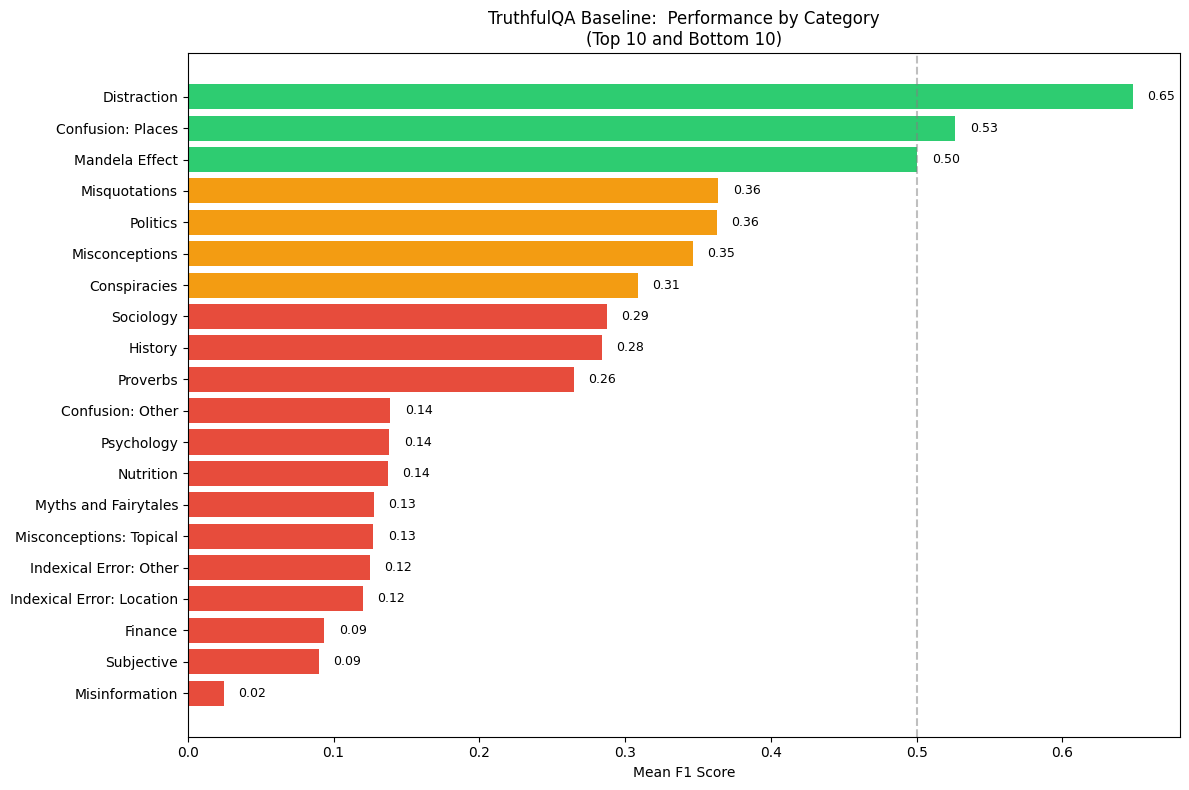

In [10]:
# Visualize category performance
fig, ax = plt.subplots(figsize=(12, 8))

# Get top 15 and bottom 15 categories by F1
top_cats = category_performance.head(10)
bottom_cats = category_performance.tail(10)

plot_data = pd.concat([top_cats, bottom_cats]).sort_values('f1_correct')

colors = ['#e74c3c' if x < 0.3 else '#f39c12' if x < 0.5 else '#2ecc71' 
          for x in plot_data['f1_correct']]

bars = ax.barh(range(len(plot_data)), plot_data['f1_correct'], color=colors)
ax.set_yticks(range(len(plot_data)))
ax.set_yticklabels(plot_data.index)
ax.set_xlabel('Mean F1 Score')
ax.set_title('TruthfulQA Baseline:  Performance by Category\n(Top 10 and Bottom 10)')
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='50% threshold')

# Add value labels
for bar, val in zip(bars, plot_data['f1_correct']):
    ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.2f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../paper/figures/truthfulqa_baseline_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. HotpotQA Baseline Experiments

Now let's establish baseline on HotpotQA for multi-hop reasoning.

In [11]:
# Load HotpotQA
HOTPOTQA_SAMPLE_SIZE = 790

hotpotqa = HotpotQADataset('../data/raw/hotpot_dev_distractor_v1.json', max_examples=2000)
print(f"Loaded HotpotQA: {len(hotpotqa)} questions")

# Get statistics
stats = hotpotqa.get_statistics()
print(f"Question types: {stats.get('question_types', {})}")
print(f"Difficulty levels: {stats.get('difficulty_levels', {})}")

Loaded HotpotQA: 2000 questions
Question types: {'bridge': 1612, 'comparison': 388}
Difficulty levels: {'easy': 0, 'medium': 0, 'hard': 2000}


In [12]:
# Stratified sampling by difficulty AND type
hotpotqa_samples = []
samples_per_cell = HOTPOTQA_SAMPLE_SIZE // 6  # 3 difficulties × 2 types = 6 cells

for difficulty in ['easy', 'medium', 'hard']:
    for q_type in ['bridge', 'comparison']:
        # Filter by both criteria
        filtered = [
            ex for ex in hotpotqa 
            if ex.difficulty == difficulty and ex.category == q_type
        ]
        
        n_samples = min(samples_per_cell, len(filtered))
        if n_samples > 0:
            sampled = random.sample(filtered, n_samples)
            hotpotqa_samples.extend(sampled)
            print(f"  {difficulty}/{q_type}: {n_samples} samples")

# If we need more, add from remaining
current_ids = set(ex.id for ex in hotpotqa_samples)
if len(hotpotqa_samples) < HOTPOTQA_SAMPLE_SIZE:
    remaining = [ex for ex in hotpotqa if ex.id not in current_ids]
    additional_needed = HOTPOTQA_SAMPLE_SIZE - len(hotpotqa_samples)
    additional = random.sample(remaining, min(additional_needed, len(remaining)))
    hotpotqa_samples.extend(additional)

random.shuffle(hotpotqa_samples)
hotpotqa_samples = hotpotqa_samples[:HOTPOTQA_SAMPLE_SIZE]

# Verify distribution
print(f"\nTotal HotpotQA samples: {len(hotpotqa_samples)}")
diff_counts = {}
type_counts = {}
for ex in hotpotqa_samples: 
    diff_counts[ex.difficulty] = diff_counts.get(ex.difficulty, 0) + 1
    type_counts[ex.category] = type_counts.get(ex.category, 0) + 1

print(f"By difficulty: {diff_counts}")
print(f"By type: {type_counts}")

  hard/bridge: 131 samples
  hard/comparison: 131 samples

Total HotpotQA samples: 790
By difficulty: {'hard': 790}
By type: {'comparison': 213, 'bridge': 577}


In [13]:
def run_hotpotqa_experiment(
    samples: list,
    llm: GeminiClient,
    prompt_template:  str = "baseline_qa_with_context",
    experiment_name: str = "baseline",
    save_intermediate: bool = True
) -> tuple[MetricsCalculator, list[dict]]:
    """Run HotpotQA experiment with given prompt template."""
    calculator = MetricsCalculator()
    raw_results = []
    prompt = get_prompt(prompt_template)
    
    print(f"\n{'='*60}")
    print(f"Running experiment: {experiment_name}")
    print(f"Prompt template: {prompt_template}")
    print(f"Total samples: {len(samples)}")
    print(f"{'='*60}\n")
    
    errors = 0
    for i, example in enumerate(tqdm(samples, desc=experiment_name)):
        # Format prompt with context (limit to avoid token limits)
        context = example.context[:6000] if example.context else ""
        formatted_prompt = prompt.format(
            question=example.question,
            context=context
        )
        
        # Get response
        try:
            response = llm.generate(formatted_prompt, max_tokens=200)
            response_text = response.text.strip()
            error = None
        except Exception as e:
            response_text = ""
            error = str(e)
            errors += 1
        
        # Calculate metrics
        result = calculator.add_result(
            example_id=example.id,
            prediction=response_text,
            ground_truth=example.correct_answer,
            metadata={
                "question_type": example.category,
                "difficulty": example.difficulty,
                "experiment": experiment_name,
            }
        )
        
        # Store raw result
        raw_results.append({
            "id": example.id,
            "question": example.question,
            "correct_answer": example.correct_answer,
            "model_response": response_text,
            "question_type": example.category,
            "difficulty": example.difficulty,
            "f1_score": result["f1_correct"],
            "exact_match": result["exact_match_correct"],
            "context_length": len(context),
            "error": error,
        })
        
        # Save intermediate results
        if save_intermediate and (i + 1) % 100 == 0:
            intermediate_path = RESULTS_DIR / f"{experiment_name}_intermediate_{i+1}.json"
            with open(intermediate_path, "w") as f:
                json.dump(raw_results, f, indent=2, default=str)
            print(f"\n  [Checkpoint] Saved {i+1} results to {intermediate_path}")
    
    print(f"\nCompleted! Total errors: {errors}/{len(samples)}")
    return calculator, raw_results

In [14]:
# Run baseline experiment on HotpotQA
hotpot_baseline_calc, hotpot_baseline_results = run_hotpotqa_experiment(
    samples=hotpotqa_samples,
    llm=llm,
    prompt_template="baseline_qa_with_context",
    experiment_name="hotpotqa_baseline"
)

print("\n" + "=" * 50)
print("BASELINE RESULTS (HotpotQA)")
print("=" * 50)
hotpot_baseline_metrics = hotpot_baseline_calc.get_aggregate_metrics()
for key, value in hotpot_baseline_metrics.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")


Running experiment: hotpotqa_baseline
Prompt template: baseline_qa_with_context
Total samples: 790



hotpotqa_baseline:  13%|█▎        | 100/790 [00:57<06:54,  1.67it/s]


  [Checkpoint] Saved 100 results to ..\data\results\hotpotqa_baseline_intermediate_100.json


hotpotqa_baseline:  25%|██▌       | 200/790 [01:58<05:37,  1.75it/s]


  [Checkpoint] Saved 200 results to ..\data\results\hotpotqa_baseline_intermediate_200.json


hotpotqa_baseline:  38%|███▊      | 300/790 [02:59<04:46,  1.71it/s]


  [Checkpoint] Saved 300 results to ..\data\results\hotpotqa_baseline_intermediate_300.json


hotpotqa_baseline:  51%|█████     | 400/790 [03:59<03:53,  1.67it/s]


  [Checkpoint] Saved 400 results to ..\data\results\hotpotqa_baseline_intermediate_400.json


hotpotqa_baseline:  63%|██████▎   | 500/790 [04:59<03:01,  1.60it/s]


  [Checkpoint] Saved 500 results to ..\data\results\hotpotqa_baseline_intermediate_500.json


hotpotqa_baseline:  76%|███████▌  | 600/790 [06:00<01:55,  1.65it/s]


  [Checkpoint] Saved 600 results to ..\data\results\hotpotqa_baseline_intermediate_600.json


hotpotqa_baseline:  89%|████████▊ | 700/790 [06:58<00:51,  1.73it/s]


  [Checkpoint] Saved 700 results to ..\data\results\hotpotqa_baseline_intermediate_700.json


hotpotqa_baseline: 100%|██████████| 790/790 [07:52<00:00,  1.67it/s]


Completed! Total errors: 0/790

BASELINE RESULTS (HotpotQA)
mean_exact_match_correct: 0.1734
count_exact_match_correct: 790
mean_f1_correct: 0.3506
count_f1_correct: 790
mean_contains_correct: 0.7215
count_contains_correct: 790
mean_truthfulness: 0.3506
count_truthfulness: 790
total_examples: 790


In [15]:
# Run chain-of-thought experiment on HotpotQA
hotpot_cot_calc, hotpot_cot_results = run_hotpotqa_experiment(
    samples=hotpotqa_samples,
    llm=llm,
    prompt_template="cot_multi_hop",
    experiment_name="hotpotqa_cot"
)

print("\n" + "=" * 50)
print("CHAIN-OF-THOUGHT RESULTS (HotpotQA)")
print("=" * 50)
hotpot_cot_metrics = hotpot_cot_calc.get_aggregate_metrics()
for key, value in hotpot_cot_metrics.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}:  {value}")


Running experiment: hotpotqa_cot
Prompt template: cot_multi_hop
Total samples: 790



hotpotqa_cot:  13%|█▎        | 100/790 [01:46<12:32,  1.09s/it]


  [Checkpoint] Saved 100 results to ..\data\results\hotpotqa_cot_intermediate_100.json


hotpotqa_cot:  25%|██▌       | 200/790 [03:35<11:05,  1.13s/it]


  [Checkpoint] Saved 200 results to ..\data\results\hotpotqa_cot_intermediate_200.json


hotpotqa_cot:  38%|███▊      | 300/790 [05:22<10:04,  1.23s/it]


  [Checkpoint] Saved 300 results to ..\data\results\hotpotqa_cot_intermediate_300.json


hotpotqa_cot:  51%|█████     | 400/790 [07:07<07:11,  1.11s/it]


  [Checkpoint] Saved 400 results to ..\data\results\hotpotqa_cot_intermediate_400.json


hotpotqa_cot:  63%|██████▎   | 500/790 [08:50<05:00,  1.04s/it]


  [Checkpoint] Saved 500 results to ..\data\results\hotpotqa_cot_intermediate_500.json


hotpotqa_cot:  76%|███████▌  | 600/790 [10:35<04:06,  1.30s/it]


  [Checkpoint] Saved 600 results to ..\data\results\hotpotqa_cot_intermediate_600.json


hotpotqa_cot:  89%|████████▊ | 700/790 [12:17<01:32,  1.03s/it]


  [Checkpoint] Saved 700 results to ..\data\results\hotpotqa_cot_intermediate_700.json


hotpotqa_cot: 100%|██████████| 790/790 [13:48<00:00,  1.05s/it]


Completed! Total errors: 0/790

CHAIN-OF-THOUGHT RESULTS (HotpotQA)
mean_exact_match_correct: 0.0076
count_exact_match_correct:  790
mean_f1_correct: 0.0927
count_f1_correct:  790
mean_contains_correct: 0.7975
count_contains_correct:  790
mean_truthfulness: 0.0927
count_truthfulness:  790
total_examples:  790


In [16]:
# Analyze HotpotQA results by difficulty
hotpot_df = pd.DataFrame(hotpot_baseline_results)

difficulty_performance = hotpot_df.groupby('difficulty').agg({
    'f1_score': 'mean',
    'exact_match': 'mean',
    'id': 'count'
}).rename(columns={'id': 'count'})

# Reorder
difficulty_order = ['easy', 'medium', 'hard']
difficulty_performance = difficulty_performance.reindex(difficulty_order)

print("HotpotQA Performance by Difficulty:")
print(difficulty_performance.to_string())

HotpotQA Performance by Difficulty:
            f1_score  exact_match  count
difficulty                              
easy             NaN          NaN    NaN
medium           NaN          NaN    NaN
hard        0.350562     0.173418  790.0


In [17]:
# Analyze by question type (bridge vs comparison)
type_performance = hotpot_df.groupby('question_type').agg({
    'f1_score':  'mean',
    'exact_match':  'mean',
    'id': 'count'
}).rename(columns={'id': 'count'})

print("\nHotpotQA Performance by Question Type:")
print(type_performance.to_string())


HotpotQA Performance by Question Type:
               f1_score  exact_match  count
question_type                              
bridge         0.381944     0.204506    577
comparison     0.265551     0.089202    213


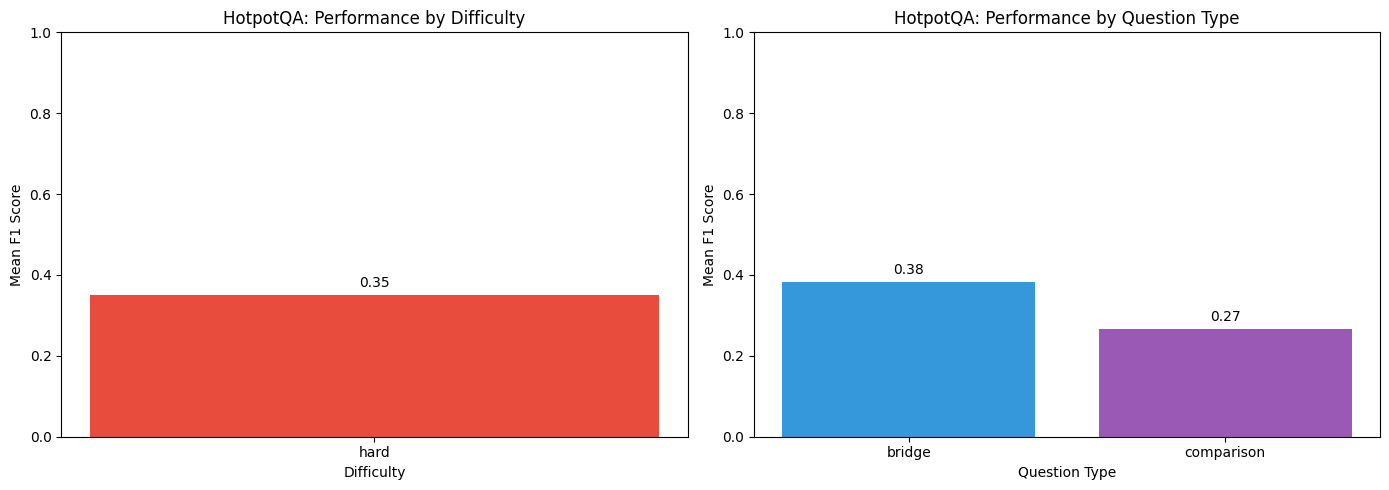

In [18]:
# Visualize HotpotQA results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# By difficulty
colors = ['#2ecc71', '#f39c12', '#e74c3c']
axes[0].bar(difficulty_performance.index, difficulty_performance['f1_score'], color=colors)
axes[0].set_xlabel('Difficulty')
axes[0].set_ylabel('Mean F1 Score')
axes[0].set_title('HotpotQA: Performance by Difficulty')
axes[0].set_ylim(0, 1)
for i, (idx, row) in enumerate(difficulty_performance.iterrows()):
    axes[0].text(i, row['f1_score'] + 0.02, f"{row['f1_score']:.2f}", ha='center')

# By question type
colors2 = ['#3498db', '#9b59b6']
axes[1].bar(type_performance.index, type_performance['f1_score'], color=colors2)
axes[1].set_xlabel('Question Type')
axes[1].set_ylabel('Mean F1 Score')
axes[1].set_title('HotpotQA: Performance by Question Type')
axes[1].set_ylim(0, 1)
for i, (idx, row) in enumerate(type_performance.iterrows()):
    axes[1].text(i, row['f1_score'] + 0.02, f"{row['f1_score']:.2f}", ha='center')

plt.tight_layout()
plt.savefig('../paper/figures/hotpotqa_baseline_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Save Results

In [19]:
# Save all results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# TruthfulQA results
truthfulqa_output = {
    "experiment": "truthfulqa_baseline",
    "timestamp": timestamp,
    "model": llm.model_name,
    "sample_size": len(truthfulqa_samples),
    "metrics": {
        "baseline": baseline_metrics,
        "chain_of_thought": cot_metrics,
    },
    "results": {
        "baseline": baseline_results,
        "chain_of_thought": cot_results,
    }
}

with open(RESULTS_DIR / f"truthfulqa_baseline_{timestamp}.json", "w") as f:
    json.dump(truthfulqa_output, f, indent=2, default=str)

# HotpotQA results
hotpotqa_output = {
    "experiment": "hotpotqa_baseline",
    "timestamp": timestamp,
    "model": llm.model_name,
    "sample_size": len(hotpotqa_samples),
    "metrics": {
        "baseline": hotpot_baseline_metrics,
        "chain_of_thought": hotpot_cot_metrics,
    },
    "results": {
        "baseline": hotpot_baseline_results,
        "chain_of_thought": hotpot_cot_results,
    }
}

with open(RESULTS_DIR / f"hotpotqa_baseline_{timestamp}.json", "w") as f:
    json.dump(hotpotqa_output, f, indent=2, default=str)

print(f"Results saved to {RESULTS_DIR}")
print(f"  - truthfulqa_baseline_{timestamp}.json")
print(f"  - hotpotqa_baseline_{timestamp}.json")

Results saved to ..\data\results
  - truthfulqa_baseline_20260115_184735.json
  - hotpotqa_baseline_20260115_184735.json


## 4. Summary

### Key Findings

In [ ]:
print("=" * 70)
print("BASELINE EXPERIMENTS SUMMARY")
print("=" * 70)

print(f"\nModel: {llm.model_name}")
print(f"API:  {llm.get_api_type()}")

print("\n" + "-" * 70)
print("TRUTHFULQA RESULTS")
print("-" * 70)
print(f"Sample size: {len(truthfulqa_samples)} questions")
print(f"\nBaseline prompting: ")
print(f"  - Mean F1 (correct): {baseline_metrics.get('mean_f1_correct', 0):.4f}")
print(f"  - Mean Truthfulness: {baseline_metrics.get('mean_truthfulness', 0):.4f}")
print(f"\nChain-of-Thought prompting:")
print(f"  - Mean F1 (correct): {cot_metrics.get('mean_f1_correct', 0):.4f}")
print(f"  - Mean Truthfulness:  {cot_metrics.get('mean_truthfulness', 0):.4f}")

print("\n" + "-" * 70)
print("HOTPOTQA RESULTS")
print("-" * 70)
print(f"Sample size: {len(hotpotqa_samples)} questions")
print(f"\nBaseline prompting:")
print(f"  - Mean F1: {hotpot_baseline_metrics.get('mean_f1_correct', 0):.4f}")
print(f"  - Exact Match: {hotpot_baseline_metrics.get('mean_exact_match_correct', 0):.4f}")
print(f"\nChain-of-Thought prompting:")
print(f"  - Mean F1: {hotpot_cot_metrics.get('mean_f1_correct', 0):.4f}")
print(f"  - Exact Match: {hotpot_cot_metrics.get('mean_exact_match_correct', 0):.4f}")

print("\n" + "=" * 70)
print("These baselines will be compared against perturbed experiments.")
print("=" * 70)

BASELINE EXPERIMENTS SUMMARY

Model: gemini-2.0-flash-lite-001
API:  vertex_ai

----------------------------------------------------------------------
TRUTHFULQA RESULTS
----------------------------------------------------------------------
Sample size: 790 questions

Baseline prompting: 
  - Mean F1 (correct): 0.2363
  - Mean Truthfulness: -0.0398

Chain-of-Thought prompting:
  - Mean F1 (correct): 0.1108
  - Mean Truthfulness:  -0.0197

----------------------------------------------------------------------
HOTPOTQA RESULTS
----------------------------------------------------------------------
Sample size: 790 questions

Baseline prompting:
  - Mean F1: 0.3506
  - Exact Match: 0.1734

Chain-of-Thought prompting:
  - Mean F1: 0.0927
  - Exact Match: 0.0076

These baselines will be compared against perturbed experiments.
Next:  Run 04_perturbation_experiments.ipynb
